In [1]:
#Ignore warnings for a cleaner display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import keras
import tensorflow as tf
import PIL

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

In [3]:
#Install dependencies
!pip install tf_explain --quiet

In [4]:
from tf_explain.core.grad_cam import GradCAM

# 1. Data Loading <a name='1'></a>

**Data Source:** 
Due to the limited memory of Kaggle notebooks, initial sample size will be 1k (rescaled to 224 by 224 for MobileNetV2). The process will be the same as before.

1. **The facial keypoints dataset:** this dataset contains the x- and y-coordinates of the facial images' five keypoints (left eye, right eye, nose, left side of the mouth, and right side of the mouth).
2. **The facial attributes dataset:** this dataset contains 40 attributes that the facial image may have (beard, female, arched eyebrows, eyeglasses, etc.) with `1` denoting that the image contains this attribute and `-1` not.

In [5]:
#Define paths to keypoints datasets
keypts_data_path = "../input/celeba-dataset/list_landmarks_align_celeba.csv"
images_data_path = "../input/celeba-dataset/img_align_celeba/img_align_celeba"

#Select only 1k images first
img_data_size = 1000

#Original image dimensions
x_og = 178
y_og = 218
image_size_ratio = x_og / y_og

# New image dimensions
x_ = 224
y_ = 224

# Image Sizes
original_image_size = (x_og, y_og)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size

In [6]:
keypts_og = pd.read_csv(keypts_data_path)[:img_data_size]
keypts_og.sample(5)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
301,000302.jpg,67,112,110,112,90,139,69,150,108,150
169,000170.jpg,69,112,108,111,88,136,72,151,105,152
681,000682.jpg,69,110,107,112,88,136,76,150,103,154
130,000131.jpg,69,111,108,112,76,138,68,150,110,153
649,000650.jpg,67,112,109,112,84,140,67,150,110,150


In [7]:
keypts_og.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,69.263000,111.201000,107.722000,111.221000,87.774000,135.110000,71.161000,151.994000,105.717000,152.146000
std,1.740362,1.116174,1.682125,1.211456,6.758002,4.493338,3.217675,1.797553,3.344562,1.744054
min,62.000000,105.000000,96.000000,101.000000,65.000000,113.000000,61.000000,145.000000,92.000000,144.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,91.000000,138.000000,73.000000,153.000000,108.000000,153.000000
max,82.000000,118.000000,116.000000,116.000000,120.000000,146.000000,83.000000,164.000000,114.000000,162.000000


In [8]:
keypts_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      1000 non-null   object
 1   lefteye_x     1000 non-null   int64 
 2   lefteye_y     1000 non-null   int64 
 3   righteye_x    1000 non-null   int64 
 4   righteye_y    1000 non-null   int64 
 5   nose_x        1000 non-null   int64 
 6   nose_y        1000 non-null   int64 
 7   leftmouth_x   1000 non-null   int64 
 8   leftmouth_y   1000 non-null   int64 
 9   rightmouth_x  1000 non-null   int64 
 10  rightmouth_y  1000 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 86.1+ KB


In [9]:
keypts_og.shape

(1000, 11)

### 1.1.2 Loading Facial Attributes Dataset <a name='1.1.2'></a>

I will be replacing the `-1` denoting a lack of the attribute to `0` so that the model can learn it as a more categorical variable than ordinal numbers.

In [10]:
#Define paths to facial attributes dataset
attr_data_path = "../input/celeba-dataset/list_attr_celeba.csv"

#Load the first 1,000 of the dataset
attr_og = pd.read_csv(attr_data_path)[:img_data_size]
attr_og.replace(-1, 0, inplace=True)

#Print the shape of the dataframe and check a sample of it
print(attr_og.shape)
attr_og.sample(5)

(1000, 41)


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
639,000640.jpg,0,0,1,0,0,0,0,1,1,...,0,1,0,1,0,0,1,0,0,1
168,000169.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
34,000035.jpg,0,1,1,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1
720,000721.jpg,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
31,000032.jpg,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0


In [11]:
attr_og.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.124000,0.275000,0.52000,0.217000,0.022000,0.149000,0.247000,0.248000,0.254000,0.148000,...,0.057000,0.51000,0.218000,0.287000,0.207000,0.044000,0.461000,0.128000,0.079000,0.754000
std,0.329746,0.446738,0.49985,0.412409,0.146757,0.356267,0.431483,0.432068,0.435515,0.355278,...,0.231959,0.50015,0.413094,0.452588,0.405358,0.205198,0.498726,0.334257,0.269874,0.430894
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
attr_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             1000 non-null   object
 1   5_o_Clock_Shadow     1000 non-null   int64 
 2   Arched_Eyebrows      1000 non-null   int64 
 3   Attractive           1000 non-null   int64 
 4   Bags_Under_Eyes      1000 non-null   int64 
 5   Bald                 1000 non-null   int64 
 6   Bangs                1000 non-null   int64 
 7   Big_Lips             1000 non-null   int64 
 8   Big_Nose             1000 non-null   int64 
 9   Black_Hair           1000 non-null   int64 
 10  Blond_Hair           1000 non-null   int64 
 11  Blurry               1000 non-null   int64 
 12  Brown_Hair           1000 non-null   int64 
 13  Bushy_Eyebrows       1000 non-null   int64 
 14  Chubby               1000 non-null   int64 
 15  Double_Chin          1000 non-null   int64 
 16  Eyeglas

### 1.1.3 Images Data
Loading the images data involves converting it to arrays so it may be used it in training the model.

In [13]:
images = []

for idx in range(keypts_og.shape[0]):
    #Retrieve path
    path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[idx].image_id))
    
    #Reading images
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    
    #Append images
    images.append(image_array)

In [14]:
#Convert to array
images = np.array(images)

images.shape

(1000, 224, 224, 3)

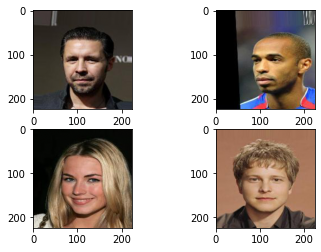

In [15]:
#Plotting sample images
idx1, idx2, idx3, idx4 = np.random.randint(0, 1000, size=4)

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(images[idx1])
axs[1,0].imshow(images[idx2])
axs[1,1].imshow(images[idx3])
axs[0,1].imshow(images[idx4])
plt.show()

# 2. Pre-Processing <a name='2'></a>
Since MobileNetV2 is primarily trained on 224 by 224 images, I will be rescaling the images that I have to 224 by 224.

In [16]:
#Create a function to resize keypts
def resize_df(df_og, x=x_og, y=None):
    """This function helps resize the dataframes with any independent coordinates 
    so that they correspond correctly with the dataset.
    
    ...
    Paremeters
    ----------
    df : dataframe
        The dataframe containing any coordinates related to the x-y values that need to be rescaled
    x : int
        The x-value to resize the image
    y : int, optional
        The y-value to resize the image (default is automatically maintaining the original x-y size ratio)
    
    Returns
    --------
    dataframe
        A dataframe containing the rescaled coordinates
    
    """
    
    if y is None:
        y = int(image_size_ratio * x)
    
    x_, y_ = x, y
    image_size_training = (x_, y_)
    
    df = df_og.copy()
    x_old, y_old = x_og, y_og
    x_new, y_new = image_size_training

    #Get ratio of new to old for rescaling
    x_ratio = x_new / x_old
    y_ratio = y_new / y_old

    keypts_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
    keypts_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']

    #Rescale the keypoints
    df[keypts_x] = (df_og[keypts_x] * x_ratio).astype('int')
    df[keypts_y] = (df_og[keypts_y] * y_ratio).astype('int')
        
    return df

In [17]:
keypts = resize_df(keypts_og, x=224, y=224)

In [18]:
#Check keypoints to see if rescaled
keypts_og.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [19]:
keypts.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,86,112,133,116,96,145,91,156,135,158
1,000002.jpg,86,113,134,115,101,138,88,155,135,157
2,000003.jpg,95,115,130,108,135,131,93,160,123,162
3,000004.jpg,90,116,135,110,127,141,89,159,127,155
4,000005.jpg,83,117,140,115,108,122,89,151,130,154


In [20]:
keypts.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,86.675000,114.182000,135.00000,114.199000,109.987000,138.11200,89.068000,155.993000,132.514000,156.145000
std,2.233464,1.188397,2.15282,1.295792,8.565758,4.49841,4.016156,1.801721,4.194687,1.749009
min,78.000000,107.000000,120.00000,103.000000,81.000000,116.00000,76.000000,148.000000,115.000000,147.000000
25%,85.000000,114.000000,134.00000,114.000000,105.000000,136.00000,86.000000,155.000000,129.000000,155.000000
50%,86.000000,114.000000,135.00000,114.000000,110.000000,138.00000,90.000000,156.000000,132.000000,156.000000
75%,88.000000,115.000000,137.00000,115.000000,114.000000,141.00000,91.000000,157.000000,135.000000,157.000000
max,103.000000,121.000000,145.00000,119.000000,151.000000,150.00000,104.000000,168.000000,143.000000,166.000000


# 3. EDA <a name='3'></a>
Now that the keypoints have been rescaled to match the new image sizes, I can visualize:
1. Distribution of the keypoints coordinates
2. Visualization of the facial attributes

## 3.1 Distribution of the Keypoints Coordinates <a name='3.1'></a>

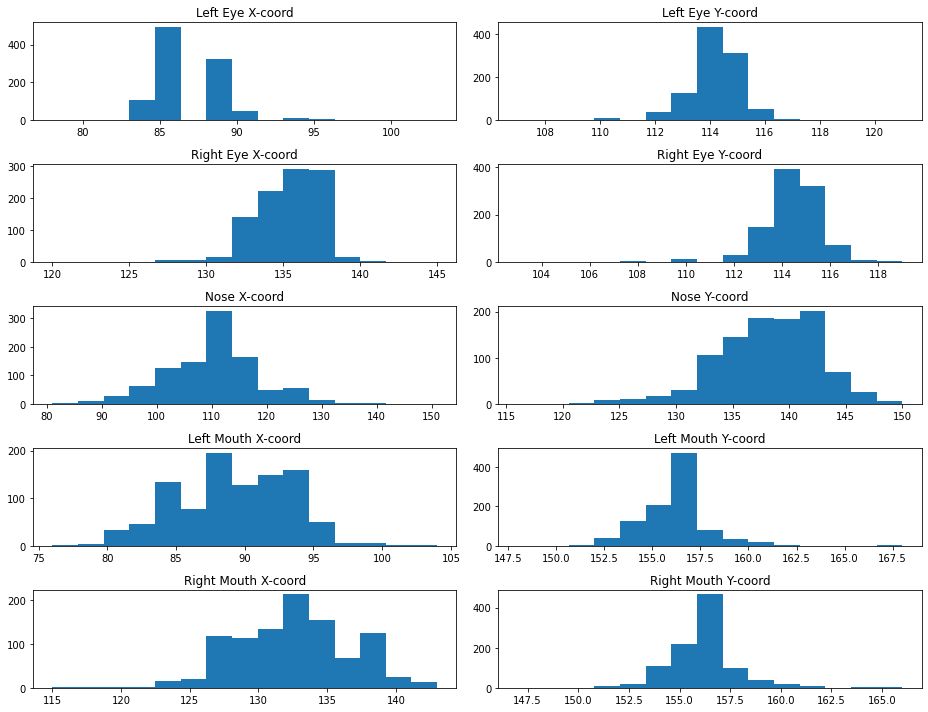

In [21]:
#Plotting distribution of the keypoints' coordinates
fig, axs = plt.subplots(5, 2, figsize=(13,10))

#Left eye
axs[0,0].hist(keypts.lefteye_x, bins=15)
axs[0,0].set_title('Left Eye X-coord')
axs[0,1].hist(keypts.lefteye_y, bins=15)
axs[0,1].set_title('Left Eye Y-coord')

#Right eye
axs[1,0].hist(keypts.righteye_x, bins=15)
axs[1,0].set_title('Right Eye X-coord')
axs[1,1].hist(keypts.righteye_y, bins=15)
axs[1,1].set_title('Right Eye Y-coord')

#Nose
axs[2,0].hist(keypts.nose_x, bins=15)
axs[2,0].set_title('Nose X-coord')
axs[2,1].hist(keypts.nose_y, bins=15)
axs[2,1].set_title('Nose Y-coord')

#Left mouth
axs[3,0].hist(keypts.leftmouth_x, bins=15)
axs[3,0].set_title('Left Mouth X-coord')
axs[3,1].hist(keypts.leftmouth_y, bins=15)
axs[3,1].set_title('Left Mouth Y-coord')

#Right mouth
axs[4,0].hist(keypts.rightmouth_x, bins=15)
axs[4,0].set_title('Right Mouth X-coord')
axs[4,1].hist(keypts.rightmouth_y, bins=15)
axs[4,1].set_title('Right Mouth Y-coord')

plt.tight_layout()
plt.show()

To add more visual context of where these coordinates lie:

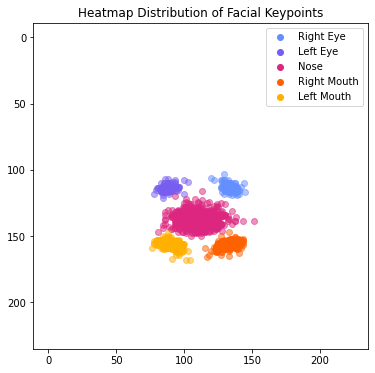

In [22]:
#Plot a sample box of with a heatmap of where the coordinates are
fig, ax = plt.subplots(figsize=(6,6))

rect = patches.Rectangle((0, 0), 224, -224, linewidth=4, facecolor='none')
ax.add_patch(rect)

#Add scatter plots of the coordinates with colorblind friendly colors
ax.scatter(keypts.righteye_x, -keypts.righteye_y, alpha=0.5, color='#648FFF', label='Right Eye')
ax.scatter(keypts.lefteye_x, -keypts.lefteye_y, alpha=0.5, color='#785EF0', label='Left Eye')
ax.scatter(keypts.nose_x, -keypts.nose_y, alpha=0.5, color='#DC267F', label='Nose')
ax.scatter(keypts.rightmouth_x, -keypts.rightmouth_y, alpha=0.5, color='#FE6100', label='Right Mouth')
ax.scatter(keypts.leftmouth_x, -keypts.leftmouth_y, alpha=0.5, color='#FFB000', label='Left Mouth')

#Add legend for the colors
leg = ax.legend()
#Set legend opacity colors to opaque (1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

#Display positive y-ticks
ax.get_yaxis().set_ticklabels([250, 200, 150, 100, 50, 0])
    
plt.title('Heatmap Distribution of Facial Keypoints')
plt.show()

### Helper Functions

In [23]:
#Read image based on index
def imread_index(index, size=image_size_training, path=images_data_path):
    """This function helps read images based on the its index by converting it to an array.
    """
    path = "{}/{}".format(str(path), str(keypts_og.iloc[index].image_id))
    
    #read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

In [24]:
#Get a list of all key points of the face
def img_keypts_list(index, df=keypts_og):
    """ This function returns a list of all the key points of the face image so 
    it's easier to plot
    """
    points_list = [df.iloc[index].lefteye_x, df.iloc[index].lefteye_y,
                  df.iloc[index].righteye_x, df.iloc[index].righteye_y,
                  df.iloc[index].nose_x, df.iloc[index].nose_y,
                  df.iloc[index].leftmouth_x, df.iloc[index].leftmouth_y,
                  df.iloc[index].rightmouth_x, df.iloc[index].rightmouth_y]
    
    return points_list

In [25]:
#Plot image with green bounding box and keypoints
def plot_face_bbox(index, df=keypts_og, size=original_image_size):
    """ This function plots the face image with its keypoints and bounding box
    """
    img = imread_index(index, size)
    points_list = img_keypts_list(index, df)
    
    #Plotting the image
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    #Plot the face points
    ax.plot(points_list[::2], points_list[1::2], 'bo-')
    
    #Plot bounding box
    width = abs(points_list[0] - points_list[8] - 60) #obtain width from left eye x to right mouth x
    height = abs(points_list[1] - points_list[9] - 75)#obtain width from left eye y to right mouth y
    rect = patches.Rectangle((points_list[0]-30, points_list[1]-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    
    #Remove axis
    plt.axis('off')
    plt.show()

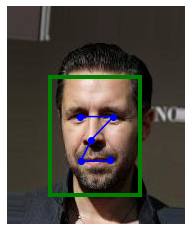

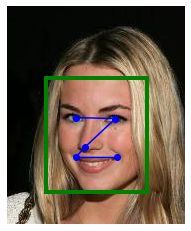

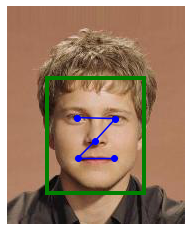

In [26]:
#test
#idx1, idx2, idx3 = np.random.randint(0, 35000, size=3)

#Test plotting sample images
plot_face_bbox(idx1)
plot_face_bbox(idx2)
plot_face_bbox(idx3)

### Split data into training and test datasets

In [27]:
# training data
train_labels = keypts[:img_data_size - 150]
train_images = images[:img_data_size - 150]


# test data (150 sample out of 1k)
test_labels = keypts[img_data_size - 150 + 1:]
test_images = images[img_data_size - 150 + 1:]

### Train and Validation Sets

In [28]:
#Dropping image_id column
y = train_labels.drop(['image_id'], axis = 1) 
X = train_images

# check
y.head(3)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,86,112,133,116,96,145,91,156,135,158
1,86,113,134,115,101,138,88,155,135,157
2,95,115,130,108,135,131,93,160,123,162


In [29]:
#Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state = 42)

#Check the ratio
X_val.shape[0]/X_train.shape[0]

0.25

### Building and Training the Model

Testing out the pre-trained MobileNet model:

In [30]:
IMG_SHAPE = image_size_training + (3,)

In [31]:
from keras.applications import MobileNetV2

mb_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [32]:
mb_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [33]:
#Freeze base model layers
mb_model.training = False

In [34]:
from keras.layers import Flatten, Dense, MaxPooling2D, Dropout, Conv2D
from keras.models import Model

#Construct the head model to be placed on top of the Xception model
headModel = mb_model.output

headModel = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(headModel)
headModel = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Flatten()(headModel)

headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)

headModel = Dense(32, activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)

headModel = Dense(16, activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)

headModel = Dense(10, activation='relu')(headModel)

In [35]:
#Combine the two models
new_model = Model(inputs=mb_model.input, outputs=headModel)

In [36]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [37]:
#Compile the model
new_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [38]:
#Fit model 
training_process = new_model.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val), batch_size=200, shuffle=True)

Epoch 1/300
4/4 [==============================] - 17s 2s/step - loss: 13985.0953 - mse: 13985.0953 - val_loss: 7931.1616 - val_mse: 7931.1616
Epoch 2/300
4/4 [==============================] - 3s 812ms/step - loss: 9164.5541 - mse: 9164.5541 - val_loss: 9267.9453 - val_mse: 9267.9453
Epoch 3/300
4/4 [==============================] - 3s 827ms/step - loss: 9451.6922 - mse: 9451.6922 - val_loss: 6640.1294 - val_mse: 6640.1294
Epoch 4/300
4/4 [==============================] - 3s 811ms/step - loss: 8366.2105 - mse: 8366.2105 - val_loss: 6521.3271 - val_mse: 6521.3271
Epoch 5/300
4/4 [==============================] - 3s 813ms/step - loss: 7522.0949 - mse: 7522.0949 - val_loss: 4991.1494 - val_mse: 4991.1494
Epoch 6/300
4/4 [==============================] - 3s 832ms/step - loss: 7056.7348 - mse: 7056.7348 - val_loss: 5115.8740 - val_mse: 5115.8740
Epoch 7/300
4/4 [==============================] - 3s 818ms/step - loss: 6706.1575 - mse: 6706.1575 - val_loss: 3824.6084 - val_mse: 3824.6084

### Saving the model:

In [39]:
#Import relevant libraries
from IPython.display import FileLink, FileLinks
import os

#Change directory
os.chdir(r'/kaggle/working')

In [40]:
#Check if dorrect directory
os.listdir()

['__notebook__.ipynb']

In [41]:
#Save model
new_model.save('mobilenetv2')

Save the model history:

In [42]:
exp = pd.DataFrame(data={'loss': [training_process.history['loss']], 'val_loss': [training_process.history['val_loss']], 'epoch': 300, 'batch': 200},
                   columns=['loss', 'val_loss', 'epoch', 'batch'])
exp.rename(index={0: 'MobileNetV2'}, inplace=True)
exp

,loss,val_loss,epoch,batch
MobileNetV2,"[13313.6201171875, 9495.9267578125, 9199.75488...","[7931.16162109375, 9267.9453125, 6640.12939453...",300,200


In [43]:
def add_exp(name, train_name, epoch, batch):
    exp.loc[name,'loss'] = np.ndarray(shape=(2,1))
    exp.loc[name,'loss'].clear()
    exp.loc[name,'loss'].extend(train_name.history['loss'])
    
    exp.loc[name,'val_loss'] = np.ndarray(shape=(2,1))
    exp.loc[name,'val_loss'].clear()
    exp.loc[name,'val_loss'].extend(train_name.history['val_loss'])
    exp.loc[name, 'epoch'] = epoch
    exp.loc[name, 'batch'] = batch

In [44]:
#Save dataframe
exp.to_csv('mobilenetv2.csv')

In [45]:
FileLink(r'mobilenetv2.csv')

/kaggle/working/mobilenetv2.csv

In [46]:
FileLinks(r'mobilenetv2')

mobilenetv2/
  saved_model.pb
mobilenetv2/variables/
  variables.index
  variables.data-00000-of-00001

### Testing the Model

In [47]:
# function to plot the image with green box around the faces
def plot_test_img(index, model, pred_or_actual = 'pred', pointsColor='ro-', boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/000{}.jpg".format(images_data_path, index),target_size=(y_og,x_og,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    model = model
    
    #Obtain predictions for key points of face
    if pred_or_actual == 'pred':
        img = tf.keras.preprocessing.image.load_img("{}/000{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255
        
        points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]
        
        #convert key pts values to original size
        x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
        y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
        
        points_list[0] = int(points_list[0] * x_ratio)
        points_list[2] = int(points_list[2] * x_ratio)
        points_list[4] = int(points_list[4] * x_ratio)
        points_list[6] = int(points_list[6] * x_ratio)
        points_list[8] = int(points_list[8] * x_ratio)
    
        points_list[1] = int(points_list[1] * y_ratio)
        points_list[3] = int(points_list[3] * y_ratio)
        points_list[5] = int(points_list[5] * y_ratio)
        points_list[7] = int(points_list[7] * y_ratio)
        points_list[9] = int(points_list[9] * y_ratio)
        
        title = 'Predicted'
        
    elif pred_or_actual == 'actual':      
        points_list = img_keypts_list(index)
        pointsColor = 'bo-'
        title = 'Actual'
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)
    ax.set_title(title)
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

[71, 110, 106, 111, 87, 129, 74, 153, 103, 154]

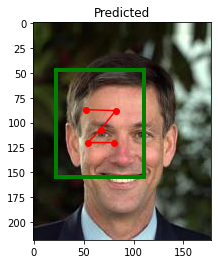

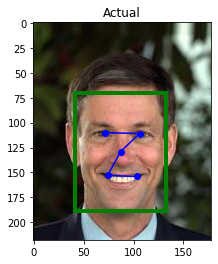

In [48]:
index = 153
plot_test_img(index, new_model, pred_or_actual = 'pred')
plot_test_img(index, new_model, pred_or_actual='actual')

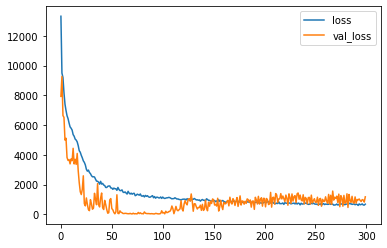

In [49]:
# losses of both training and validation sets
loss = training_process.history['loss']
val_loss = training_process.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

### Evaluation of Model

Using the test data to evaluate the model performance:

In [50]:
test_lbs = test_labels.copy()
test_lbs = test_lbs.drop(['image_id'], axis=1)

loss, mse = new_model.evaluate(test_images, test_labels.drop(['image_id'], axis=1), verbose=0)

print("MSE for Test Data: {:.5f}".format(mse))

MSE for Test Data: 1148.93787


Comparing the distribution of the predicted vs. actual keypoints:

In [51]:
predictions = new_model.predict(images.reshape(-1,y_,x_,3)).astype('int')
predictions.shape

(1000, 10)

In [52]:
# #Obtain keypoint names
cols = list(keypts.columns)
cols.remove('image_id')

# #Convert predictions to dataframe
pred_df = pd.DataFrame(predictions, columns=cols)
print(pred_df.shape)
pred_df.sample(3)

(1000, 10)


,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
108,63,83,99,83,81,102,65,113,95,114
650,63,83,99,83,81,102,65,114,96,114
219,64,84,100,84,82,103,66,115,97,116


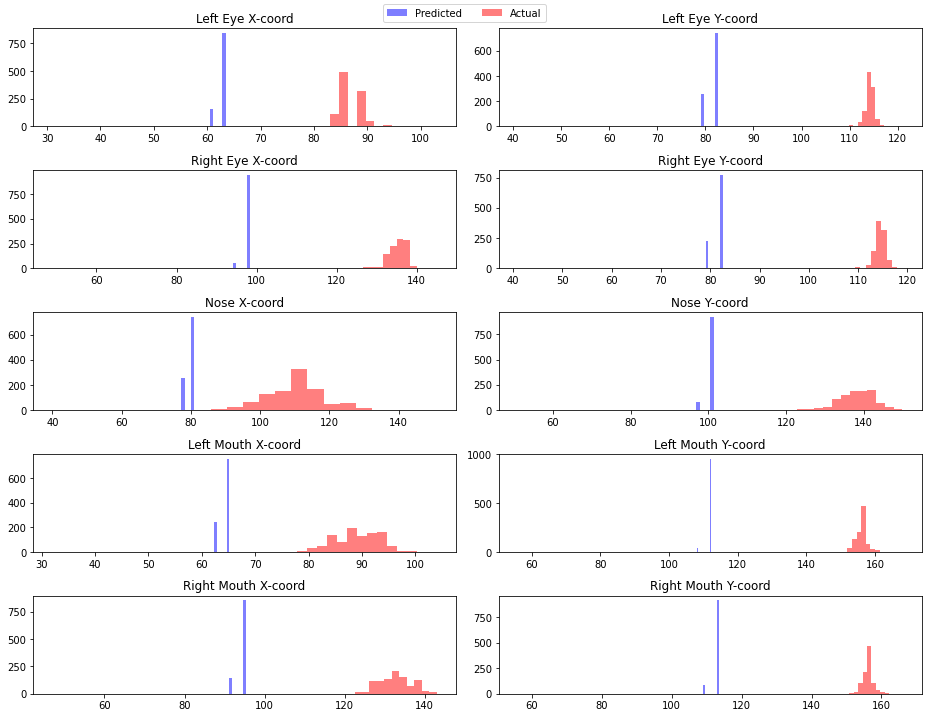

In [53]:
#Plotting distribution of the keypoints' coordinates
fig, axs = plt.subplots(5, 2, figsize=(13,10))

#Left eye
axs[0,0].hist(pred_df.lefteye_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.7)
axs[0,0].hist(keypts.lefteye_x, bins=15, alpha=0.5, color='red', label='Actual')
axs[0,0].set_title('Left Eye X-coord')
axs[0,1].hist(pred_df.lefteye_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.5)
axs[0,1].hist(keypts.lefteye_y, bins=15, alpha=0.5, color='red', label='Actual')
axs[0,1].set_title('Left Eye Y-coord')

#Right eye
axs[1,0].hist(pred_df.righteye_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.9)
axs[1,0].hist(keypts.righteye_x, bins=15, alpha=0.5, color='red', label='Actual')
axs[1,0].set_title('Right Eye X-coord')
axs[1,1].hist(pred_df.righteye_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.5)
axs[1,1].hist(keypts.righteye_y, bins=15, alpha=0.5, color='red', label='Actual')
axs[1,1].set_title('Right Eye Y-coord')

#Nose
axs[2,0].hist(pred_df.nose_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.9)
axs[2,0].hist(keypts.nose_x, bins=15, alpha=0.5, color='red', label='Actual')
axs[2,0].set_title('Nose X-coord')
axs[2,1].hist(pred_df.nose_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.9)
axs[2,1].hist(keypts.nose_y, bins=15, alpha=0.5, color='red', label='Actual')
axs[2,1].set_title('Nose Y-coord')

#Left mouth
axs[3,0].hist(pred_df.leftmouth_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.5)
axs[3,0].hist(keypts.leftmouth_x, bins=15, alpha=0.5, color='red', label='Actual')
axs[3,0].set_title('Left Mouth X-coord')
axs[3,1].hist(pred_df.leftmouth_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.3)
axs[3,1].hist(keypts.leftmouth_y, bins=15, alpha=0.5, color='red', label='Actual')
axs[3,1].set_title('Left Mouth Y-coord')

#Right mouth
axs[4,0].hist(pred_df.rightmouth_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.7)
axs[4,0].hist(keypts.rightmouth_x, bins=15, alpha=0.5, color='red', label='Actual')
axs[4,0].set_title('Right Mouth X-coord')
axs[4,1].hist(pred_df.rightmouth_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.5)
axs[4,1].hist(keypts.rightmouth_y, bins=15, alpha=0.5, color='red', label='Actual')
axs[4,1].set_title('Right Mouth Y-coord')

#Format legend
lines_labels = [axs[0,0].get_legend_handles_labels()]
lines, labels = [sum(i, []) for i in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=2)

plt.tight_layout()
plt.show()

### Distribution of MSE

In [54]:
#Obtain data and their actual keypoint values
im2 = images.copy()
actual2 = np.asarray(keypts.drop(['image_id'], axis=1)).transpose().reshape(-1,10).astype(np.float32)

In [55]:
mse_dist = []

#Collect MSEs for dataset
for data in range(im2.shape[0]):
    loss, mse = new_model.evaluate(im2[data].reshape(-1, x_, y_, 3), actual2[data].reshape(-1, 10), verbose=0)
    mse_dist.append(mse)
    if data%500 == 0:
        print("Currently at {}/{} for MSE collection.".format(data, im2.shape[0]))

Currently at 0/1000 for MSE collection.
Currently at 500/1000 for MSE collection.


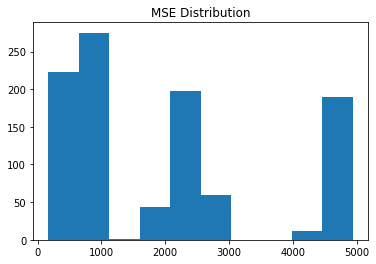

In [56]:
#Plot the MSE Distribution
plt.hist(mse_dist)
plt.title('MSE Distribution')
plt.show()

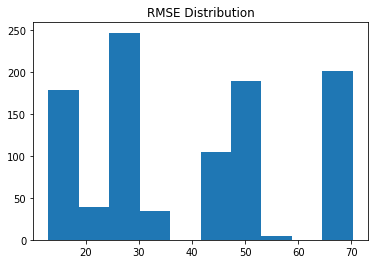

In [57]:
#Plot RMSE Distribution for easy interpretability
rmse_dist = np.sqrt(mse_dist)

plt.hist(rmse_dist)
plt.title('RMSE Distribution')
plt.show()

# Explainability of the model

Instead of blindly trusting the 'black box,' I'm going to be delving further into what is going on under the hood to make sure there's some explainability to the model.

In [58]:
#Take a random image from the dataset
IDX = 540

path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[IDX].image_id))
im = PIL.Image.open(path).resize(image_size_training)
im_array = np.asarray(im)

im = im_array.reshape(-1, y_, x_, 3)
im.shape

(1, 224, 224, 3)

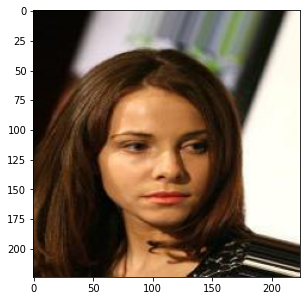

In [59]:
fig = plt.figure(figsize=(6,6*image_size_ratio))
plt.imshow(im_array/255)
plt.show()

In [60]:
#Check the loss and accuracy of the sample image
#obtain the actual value and reshape it as a tensor
actual = np.asarray(keypts.iloc[IDX].drop(['image_id'])).transpose().reshape(-1,10).astype(np.float32)

loss, mse = new_model.evaluate(im, actual)

1/1 [==============================] - 1s 753ms/step - loss: 3565.5398 - mse: 3565.5398


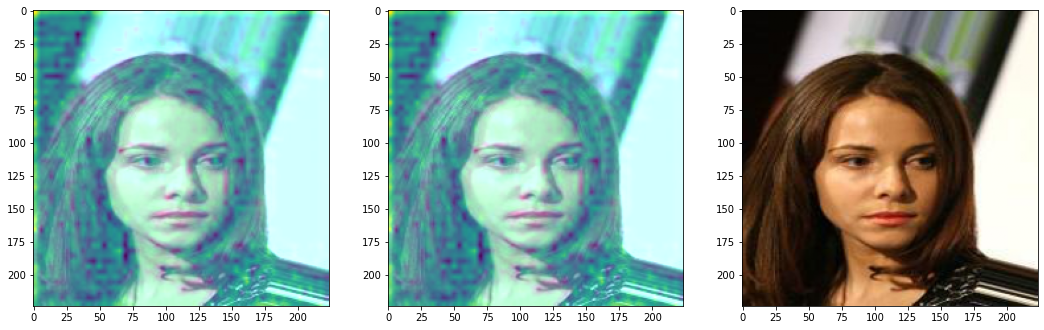

In [61]:
#Visualize GradCAM output from 1st conv layer
explainer = GradCAM()

grid1 = explainer.explain((im, None), new_model, 1, 'block_3_expand')
grid2 = explainer.explain((im, None), new_model, 4, 'block_3_expand')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)

The model is looking at the edges and outlines of the shapes, which makes sense since it's looking at one of its early layers. Going deeper into the CNN model, however, gives more model explainability.

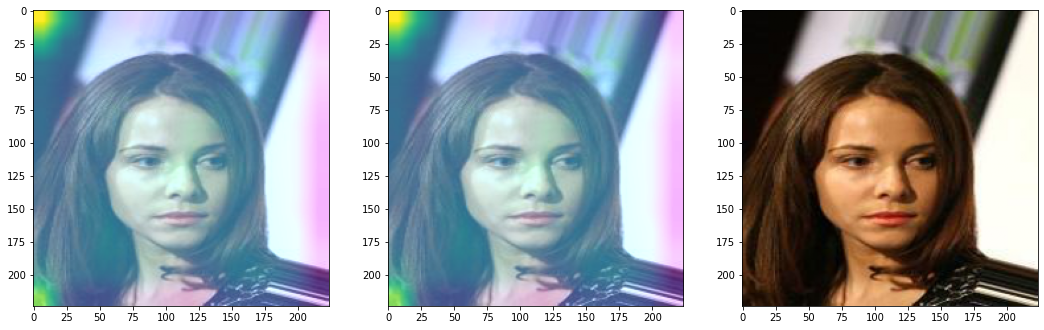

In [62]:
#Visualize GradCAM output from 4th conv layer
grid1 = explainer.explain((im, None), new_model, 1, 'block_13_expand')
grid2 = explainer.explain((im, None), new_model, 4, 'block_13_expand')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)

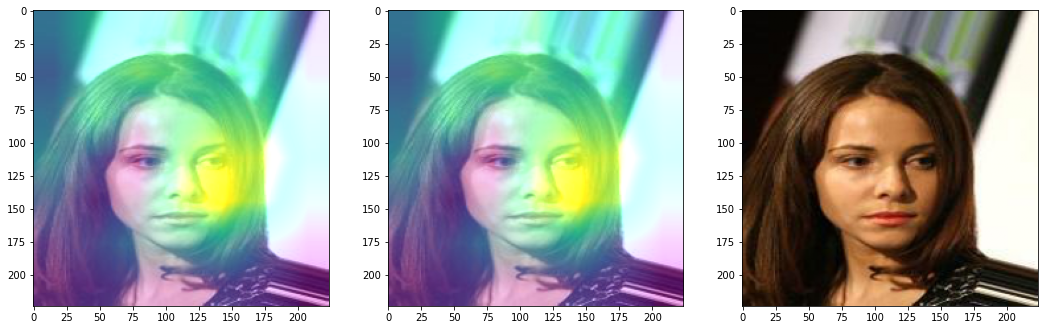

In [63]:
#Visualize GradCAM output from last conv layer
grid1 = explainer.explain((im, None), new_model, 1, 'conv2d_1')
grid2 = explainer.explain((im, None), new_model, 4, 'conv2d_1')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)